In [64]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1' # Must be before importing keras!
import sys
sys.path.insert(0,"/home/kal/CTCF/modules/")
sys.path.insert(0,"/home/kal/CTCF/mass_CTCF/modules/")
import tf_memory_limit
#import matplotlib; matplotlib.use('Agg')  # Must be before importing matplotlib.pyplot or before importing pylab!
from keras import backend as K
import tensorflow as tf
import numpy as np
import ctcfgen
import pandas as pd
import ucscgenome
from convnet import Bias
from keras.models import load_model, Model
from keras.layers import Input, Activation
import viz_sequence
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.signal import correlate2d

batch_size=32
input_window=256

model_path='/home/kal/CTCF/mass_CTCF/output/20170630_173919/20170630_173919_weights__289_0.95.hdf5'
gen_path='/home/kal/data/ctcfgen_data.hdf5'
bed_path = '/home/kal/data/final_atac.bed'
meme_path = '/home/kal/data/CTCF.meme'

out_dir = os.path.dirname(model_path)
genome = ucscgenome.Genome('/home/kal/.ucscgenome/hg19.2bit')

In [65]:
# load the model
model = load_model(model_path, custom_objects={'Bias':Bias})

# load the generator
gen = ctcfgen.CTCFGeneratorhdf5(gen_path)

# load the bed file
peaks = pd.read_table(bed_path, header=None)
peaks.columns = 'chr start end ctcf pwm ml'.split()

# get the symbolic outputs of each "key" layer.
layer_dict = dict([(layer.name, layer) for layer in model.layers])
print(layer_dict.keys())

dict_keys(['input_1', 'conv1d_4', 'spatial_dropout1d_2', 'activation_1', 'lambda_1', 'conv1d_1', 'conv1d_2', 'wide_scan', 'spatial_dropout1d_3', 'spatial_dropout1d_1', 'stackmax', 'final_conv', 'spatial_dropout1d_4', 'bias', 'conv1d_3'])


In [66]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

In [67]:
def rejection(seq_a, seq_b):
    """utiliy function to compute rejection of a from b"""
    out = list()
    for a, b in zip(seq_a, seq_b):
        if np.linalg.norm(b) == 0:
            out.append(a)
        else:
            out.append(a - ((np.dot(a, b) / (np.linalg.norm(b)**2)) * b))
    return np.asarray(out)

In [68]:
def softmax(batch):
    norm_batch = []
    for seq in batch:
        norm_batch.append([_softmax(base) for base in seq])
    return np.asarray(norm_batch)
    
def _softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference

In [69]:
def build_iterate(model, layer_name, filter_index=0, ):
    
    # set a placeholder input
    encoded_seq = model.input

    # build a function that maximizes the activation of the nth filter of the layer considered
    if layer_name == 'final_output':
        activations = model.output

        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(K.sum(activations), encoded_seq)[0]

    else:
        layer_output = layer_dict[layer_name].output

        activations = layer_output[:, :, filter_index]
        combined_activation = activations[:32] # we only generate forward sequences anyway

        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(K.sum(K.max(combined_activation, axis=1)), encoded_seq)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([encoded_seq, K.learning_phase()], [activations, grads])
    
    return iterate

In [70]:
def good_batch_gen(batch_gen, op):
    #get a threshold value
    seqs = next(batch_gen)
    activations, grads = op([seqs, 0])
    max_value_1 = np.max(activations)
    seqs = next(batch_gen)
    activations, grads = op([seqs, 0])
    max_value_2 = np.max(activations)
    max_value = min(max_value_1, max_value_2)
    
    while True:
        good_batch = []
        while len(good_batch) < 32:
            seqs = next(batch_gen)
            activations, grads = op([seqs, 0])
            if layer_name == 'final_output':
                activations = np.append(activations, activations)
            importances = np.sum(grads, axis=-1)
            for seq_value, factivations, ractivations, importance_value in zip(seqs, activations[:32],activations[32:], importances):
                if np.max(factivations) >= max_value:
                    peak_index = np.argmax(importance_value)
                    good_batch.append(np.roll(seq_value, input_window//2-peak_index, axis=0))
                #if np.max(ractivations) >= max_value:
                    #peak_index = np.argmax(importance_value)
                    #reverse = ctcfgen.rc(np.asarray([seq_value]))[0]
                    #good_batch.append(np.roll(reverse, input_window//2-peak_index, axis=0))
        yield np.asarray(good_batch)[:32, :, :]

In [71]:
def localize(row, verb=False):
    # break the sequence into overlapping tiles
    tile_seqs = list()
    num_tiles = int((row['end']-row['start']) / input_window) + ((row['end']-row['start']) % input_window > 0)
    if verb:
        print(num_tiles)
    for idx in range(num_tiles):
        if row['start'] + idx*input_window - input_window//2 > 0:
            seq = genome[row['chr']][row['start'] + idx*input_window - input_window//2:row['start'] + (idx+1)*input_window - input_window//2].lower()
            tile_seqs.append(ctcfgen.encode(np.fromstring(seq, dtype=np.uint8)))
        else:
            buffered_seq = np.zeros((256,4))
            buffered_seq[:row['start'] + (idx+1)*input_window - input_window//2] = genome[row['chr']][0:row['start'] + (idx+1)*input_window - input_window//2]
            tile_seqs.append(ctcfgen.encode(np.fromstring(buffered_seq).lower(), dtype=np.uint8))
        seq = genome[row['chr']][row['start'] + idx*input_window:row['start'] + (idx+1)*input_window].lower()
        tile_seqs.append(ctcfgen.encode(np.fromstring(seq, dtype=np.uint8)))
        
    tile_seqs= np.asarray(tile_seqs)
    tile_iter = iter(tile_seqs)
    
    # get a batch generator
    batches = ctcfgen.filled_batch(tile_iter, batch_size=batch_size)
    
    # figure out where the max prediction is coming from
    preds = list()
    for batch in batches:
        preds.append(model.predict_on_batch(batch))
    preds = np.asarray(preds).reshape((-1))[:tile_seqs.shape[0]]
    
    # get a tile centered there
    max_idx = np.argmax(preds)
    max_pred = np.max(preds)
    max_tile = batch.reshape((-1, 256, 4))[max_idx]
    if verb:
        print(max_idx)
        print(max_pred)
        print(preds)
    
    return max_tile, max_pred

In [165]:
def limited_dream(input_seqs, iterate_op, limit_op, n=20, verb=0):
    # get benchmark pwm locations
    pwm, memes, positions = get_pwm(input_seqs, get_score=True)

    # get benchmark sequence   
    orig_seqs = input_seqs
    checkpoint_seqs = orig_seqs

    # find an appropriate step size
    activations, grads = iterate_op([input_seqs, 0])
    max_grad = np.amax(grads, axis=(2, 1)) + 1
    step = 1/(max_grad)
    step = np.asarray([np.full((input_window, 4), elem) for elem in step])
    
    if verb > 0:
        print('initial sequence')
        viz_sequence.plot_icweights(input_seqs[0])
        
    # take an initial step
    #input_seqs = softmax(input_seqs + constrain(grads, input_seqs, get_pwm, memes, positions)*step)
    pwm = get_pwm(input_seqs, memes=memes, positions=positions, get_score=True)
        
    for i in range(n):
        #print some stuff
        if i % 10 == 0 and verb > 1:
            print('sequence after '+ str(i+1) + ' iterations')
            viz_sequence.plot_icweights(input_seqs[0])
            
        # get the gradients 
        activations, grads = iterate_op([input_seqs, 0])
        #get pwm independent update
        update = constrain(grads, input_seqs, get_pwm, memes, positions)
    
        #check changes are still made
        if (0 < np.amax(input_seqs - checkpoint_seqs) < 0.0001) or (np.amax(update) < .1):
            if verb != 0:
                print('sequence after '+ str(i+1) + ' iterations')
                viz_sequence.plot_weights(input_seqs[0])
                print('Nothing is happening')
            break

        # update the sequence
        input_seqs = np.log(input_seqs + update*step + .01)
        input_seqs = softmax(input_seqs)        
        
    if verb > 0:
        print('final sequence after '+ str(i+1) + ' iterations')
        viz_sequence.plot_icweights(input_seqs[0])
        pwm = get_pwm(input_seqs, memes=memes, positions=positions, get_score=True)
               
        return input_seqs

In [159]:
def constrain(grads, input_seqs, limit_op, memes, positions, verb=False):
    limits = limit_op(input_seqs, memes=memes, positions=positions)
    constrained = list()
    #for grad, limit in zip(grads, limits):
        #constrained.append(rejection(grad, limit))
        
    for grad, position, meme in zip(grads, positions, memes):
        block = np.copy(grad)
        block[position:position+meme.shape[0]] = np.zeros((meme.shape))
        constrained.append(block)
    
    if verb:
        print('gradients')
        viz_sequence.plot_weights(grads[0])
        print('filters')
        viz_sequence.plot_weights(limits[0])
        print('constrained grads')
        viz_sequence.plot_weights(np.asarray(constrained)[0])
    return np.asarray(constrained)

MEME:


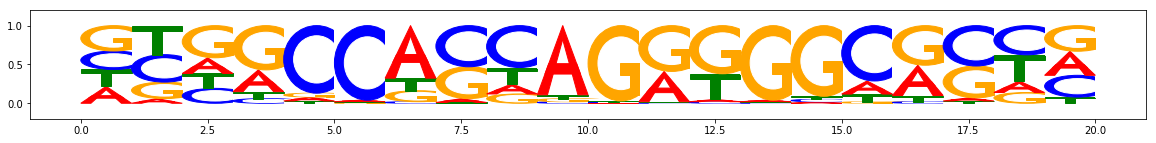

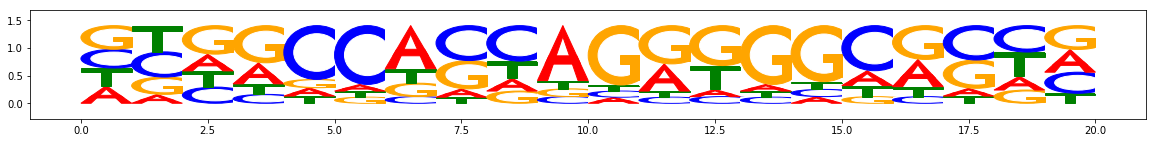

normalized:


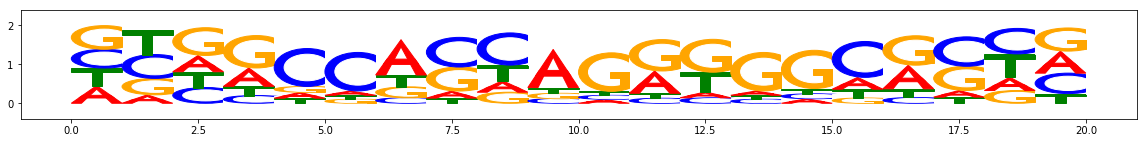

MEME:


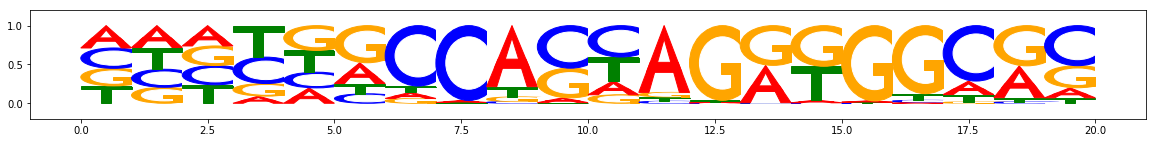

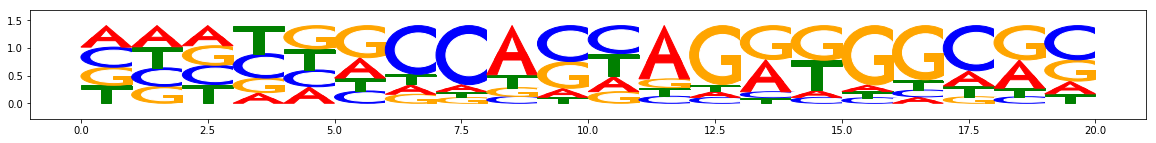

normalized:


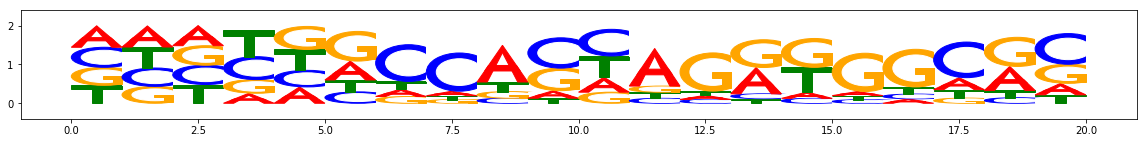

MEME:


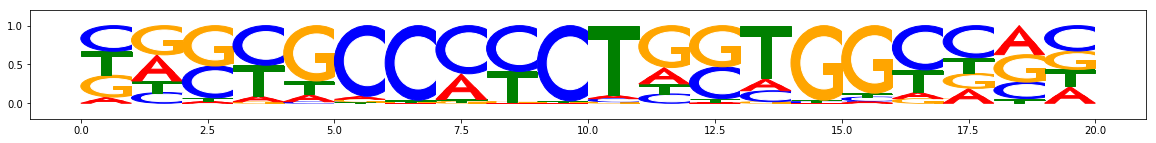

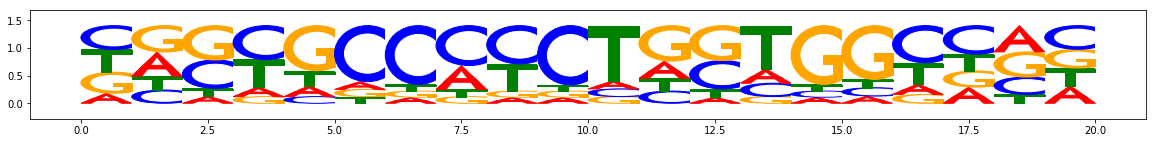

normalized:


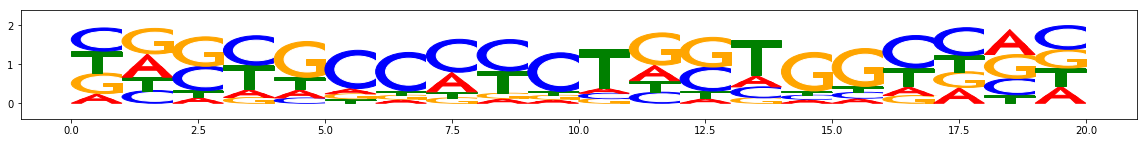

MEME:


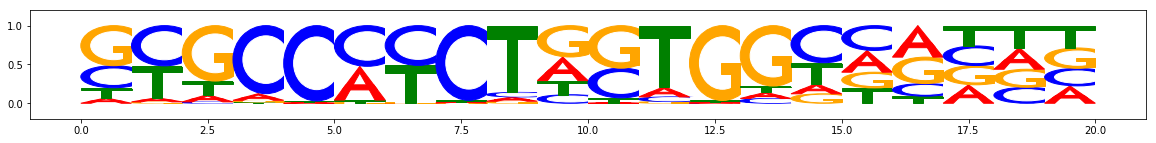

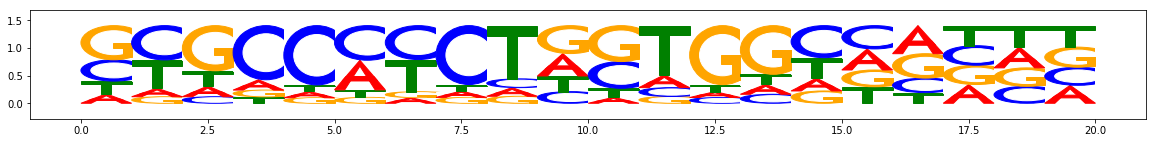

normalized:


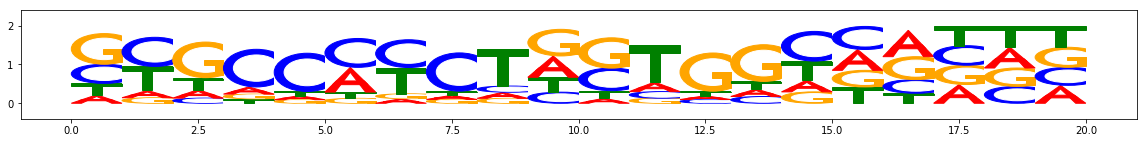

In [86]:
# process the memes
with open(meme_path, 'r') as infile:
    meme_length = -1
    CTCF_memes = list()
    for line in infile.readlines():
        if 'letter-probability matrix' in line:
            meme_length = int(line.split()[5])
            this_meme_lines = list()
        elif meme_length > 0:
            this_meme_lines.append([float(item.strip()) for item in line.split()])
            meme_length = meme_length - 1
        elif meme_length == 0:
            this_meme = np.asarray(this_meme_lines)
            CTCF_memes.append(this_meme)
            meme_length = -1
    if meme_length == 0:
        this_meme = np.asarray(this_meme_lines)
        CTCF_memes.append(this_meme)
        meme_length = -1
        
# add rcs of memes
rcs = list()
for meme in CTCF_memes:
    rcs.append(meme[::-1, ::-1])
CTCF_memes = CTCF_memes + rcs
    
    
psuedocount=0.1
# get the transformed memes
transformed_memes = list()
for meme in CTCF_memes:
    # add psuedo count
    print('MEME:')
    viz_sequence.plot_weights(meme)
    meme = meme + psuedocount 
    viz_sequence.plot_weights(meme)
    # normalize
    print('normalized:')
    norms = np.repeat(np.linalg.norm(meme, axis=1), 4).reshape((-1, 4))
    meme = meme/norms
    viz_sequence.plot_weights(meme)
    # log transform
    #print('Log transformed')
    #meme = np.log(meme)
    #viz_sequence.plot_weights(meme)
    # shift up
    #print('shift')
    #min = np.amin(meme)
    #meme = meme - min
    #viz_sequence.plot_weights(meme)
    transformed_memes.append(meme)
    

def get_pwm(input_seqs, memes=None, positions=None, meme_library=transformed_memes, get_score=False):  
    # get position and meme if not specified
    if memes == None and positions == None:
        get_loc = True
        memes = list()
        positions = list()
        for seq in input_seqs:
            best_score = -np.inf
            for test_meme in meme_library:
                correlations = correlate2d(seq, test_meme, mode='valid')
                if np.max(correlations) > best_score:
                    best_score = np.max(correlations)
                    best_location = np.argmax(correlations)
                    best_filter = test_meme
            positions.append(best_location)
            memes.append(best_filter)
    else:
        get_loc = False
    
    # get the pwms
    output_scores = list()
    for meme, position in zip(memes, positions):
        pwm = np.zeros(input_seqs[0].shape)
        pwm[position:position+meme.shape[0]] = meme
        output_scores.append(pwm)    
    
    if get_score:
        corr = correlate2d(input_seqs[0][positions[0]:positions[0]+memes[0].shape[0]], memes[0], mode='valid')
        print('PWM score:' + str(np.max(corr)))
            
    if get_loc:
        return np.asarray(output_scores), memes, positions
    else:
        return np.asarray(output_scores)

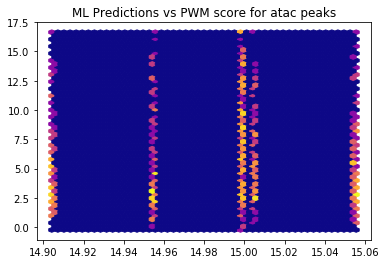

(642, 6)


In [12]:
# find seqs of interest
contstrained_peaks = peaks[(abs(peaks['pwm'] -15) < .1)]
contstrained_peaks = contstrained_peaks[contstrained_peaks['ctcf']]

# make a plot of the two predictions vs each other
plt.hexbin(contstrained_peaks['pwm'].tolist(), contstrained_peaks['ml'].tolist(), gridsize=50, bins='log', cmap='plasma')
plt.title('ML Predictions vs PWM score for atac peaks')
plt.show()
print(contstrained_peaks.shape)

signal_seqs = list()

for index, row in contstrained_peaks.iterrows():
    this_seq, max_pred = localize(row)    
    signal_seqs.append(this_seq)

contstrained_peaks['signal_seq'] = signal_seqs

PWM score:13.9994023713
initial sequence


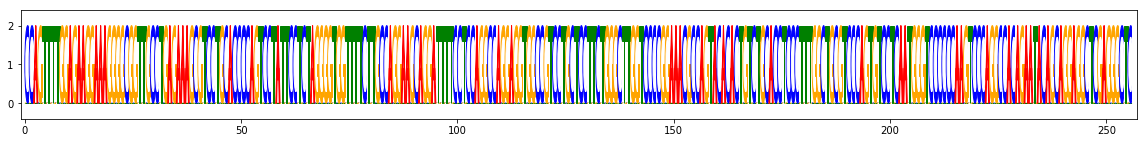

PWM score:13.9994023713
sequence after 1 iterations


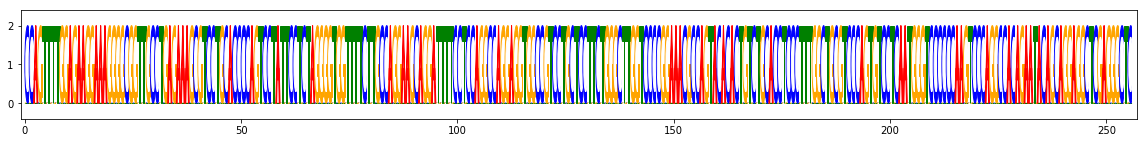

/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in log


final sequence after 5 iterations


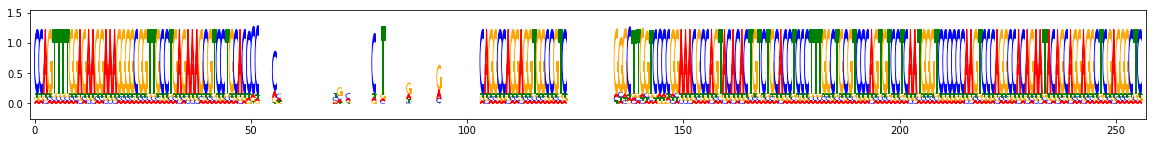

PWM score:12.9637415605


In [166]:
# build the grads model
iterate_op = build_iterate(model, 'final_output')

#find sequences of interest
g = ctcfgen.filled_batch(iter(contstrained_peaks['signal_seq']), batch_size=32)
input_seqs = next(g)

limit_op = get_pwm

# dream the sequences
input_seqs = limited_dream(input_seqs, iterate_op, limit_op, verb=2, n=5)

In [ ]:
for seq in input_seqs:
    viz_sequence.plot_icweights(seq)

In [156]:
iterate_op = build_iterate(model, 'final_output')
g = ctcfgen.filled_batch(iter(contstrained_peaks['signal_seq']), batch_size=32)
input_seqs = next(g)

viz_sequence.plot_weight(input_seqs)
viz_sequence.plot_weight(input_seqs)

orig score
PWM score:13.9994023713
PWM score:33.9994023713
PWM score:13.1287778732


/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log


-1.21430643318e-15


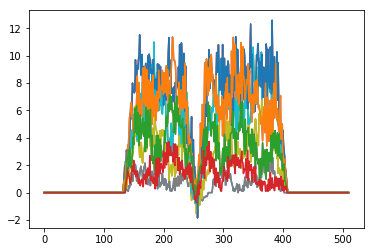

In [79]:
dots = [np.dot(a,b) for a, b in zip(reject, pwm[0])]
print(np.sum(dots))

plt.plot(correlate2d(reject, pwm[0]))
plt.show()